In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob 
import os
import json

from utils import *
from skimage.transform import rescale, resize
from sklearn.model_selection import train_test_split
from pyhdf.SD import SD, SDC



In [27]:
data_path = '../data/'
colls = ['set1', 'set2']
size = 128
scales = [0.8]
clean_tiles = []

files = glob.glob(os.path.join(data_path, 'set1', 'raw', '*.hdf'))

with open(os.path.join(data_path, 'set1', 'query.json')) as f:
    meta = json.load(f)
    
for file in files:
    basename = os.path.splitext(os.path.basename(file))[0]
    if not meta['metadata'][basename]['umm']['MeasuredParameters'][0]['QAFlags']['AutomaticQualityFlag'] == 'Passed':
        continue
    
    lst = get_lst_day(file)
    tiles = divide_image(lst, (128, 128), (64, 64))

    for tile in tiles:
        if not 0 in tile:
            clean_tiles.append(tile)
            
np.random.shuffle(clean_tiles)
noisy = []

for tile in clean_tiles:
    for scale in scales:
        resized = resize(tile, (scale*tile.shape[0], scale*tile.shape[1]), anti_aliasing=True)
        resized = resize(resized, (tile.shape[0], tile.shape[1]))
        noisy.append(resized)
        
train_idx = int(0.8 * len(clean_tiles))
size_val = (len(clean_tiles) - train_idx)//2

train_data = clean_tiles[0:train_idx]
train_noisy = noisy[0:train_idx]

valid_data = clean_tiles[train_idx:train_idx+size_val]
valid_noisy = noisy[train_idx:train_idx+size_val]

test_data = clean_tiles[train_idx+size_val::]
test_noisy = noisy[train_idx+size_val::]

print('dataset len: {}\n train_len: {}\n valid_len: {}\n test_len: {}'.format(len(clean_tiles), len(train_data), len(valid_data), len(test_data)))

data = {
    'train': (train_data, train_noisy),
    'valid': (valid_data, valid_noisy),
    'test': (test_data, test_noisy)
}

for subset, value in data.items():
    with h5py.File(subset + '.hdf5', 'w') as f:
        print('creating '+ subset)
        length = len(value[0])
        imgs = f.create_dataset('images', (length, 128, 128), data=value[0])
        noisy_imgs = f.create_dataset('noisy',(length, 128, 128), data=value[1])


dataset len: 6373
 train_len: 5098
 valid_len: 637
 test_len: 638
creating train
creating valid
creating test


Data Validation


In [28]:
import h5py
import matplotlib.pyplot as plt
from dataset import *
import seaborn as sns

In [29]:
dataset = LSTDataset('./train.hdf5')

In [30]:
#check for outliers

for sample in dataset:
    print(np.mean(sample))
    assert [x > 200 for x in sample], 'too low'
    assert [x < 350 for x in sample], 'too high' 

311.49029052734375
306.4138012695313
311.1213391113281
301.6685498046875
306.65208984375
321.1639245605469
289.0994604492188
306.44196411132816
293.66874145507813
300.10029541015626
298.802998046875
301.66576904296875
291.7511828613281
301.08476196289064
321.156884765625
310.72563720703124
303.34039916992185
295.8045910644531
305.6179992675781
307.7705712890625
314.8337878417969
313.56174804687504
305.0018579101562
299.60478271484374
311.85692626953124
298.40355590820315
293.5161560058594
311.9015856933594
311.1587097167969
308.9053979492187
302.8822668457031
310.9946655273437
302.5721765136719
299.03542846679693
301.8838146972656
307.5081506347656
306.30761352539065
301.57133300781254
315.18943603515623
316.39103271484373
320.27690185546874
305.60039428710934
303.69880126953126
314.9505712890625
304.5704040527344
298.66945068359377
303.25155151367187
293.1833251953125
310.6212060546875
305.798896484375
304.46932128906246
315.46351806640627
303.40680908203126
308.2095153808594
315.6471

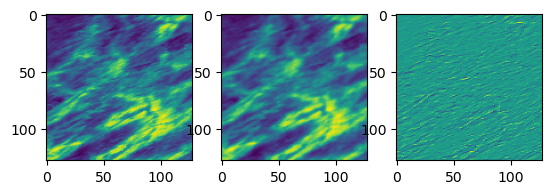

In [39]:
h5f = h5py.File('./train.hdf5', 'r')
sample = h5f['images'][1231]
noise = h5f['noisy'][1231] 
h5f.close()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(sample)
ax[1].imshow(noise)
ax[2].imshow(noise-sample)


Check outputs

In [1]:
import os
import numpy as np
import seaborn as sns
import lightning as L
import torch.optim as optim
import glob
import h5py
import pandas as pd
import matplotlib.pyplot as plt

from lightning.pytorch.loggers import CSVLogger
from skimage.transform import resize
from torch.utils.data import DataLoader
from models import *
from utils import *
from dataset import *

In [2]:
LR = 1e-3
DECAY = 1e-7 
EPOCHS = 10
BATCH_SIZE = 64
PATCH_SIZE = 128

In [3]:
path = '../data/super_res_set1'
test = LSTDataset(os.path.join(path, 'test.hdf5'))


In [4]:
train_loss = []
valid_loss = []

if torch.cuda.is_available():
  device = torch.device(torch.cuda.current_device())
else:
  raise RuntimeError('No GPU')

model = DnCNN(channels=1).to(device)

In [7]:
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=DECAY)
loss_fn = nn.MSELoss(reduction='sum')

modis_model = dncnn_lightning.load_from_checkpoint('logs/super_res1/version_16/checkpoints/epoch=9-step=800.ckpt', model=model, optimizer=optimizer, loss_fn=loss_fn)

In [24]:
def pre(batch):
    x, y = batch
    noise = x - y
    noise = noise.reshape(1, 1, noise.shape[0], noise.shape[1])
    y = y.reshape(1, 1, y.shape[0], y.shape[1])
    noise, y = torch.Tensor(noise), torch.Tensor(y)
    noise, y = noise.type(torch.cuda.FloatTensor), y.type(torch.cuda.FloatTensor)
    return  noise, y

In [25]:
sample = test[np.random.randint(0, len(test))]

In [26]:
noise, noisy = pre(sample)

preds = modis_model.forward(noisy)

In [34]:
preds.shape

torch.Size([1, 1, 128, 128])

In [41]:
sample[1].shape

(128, 128)

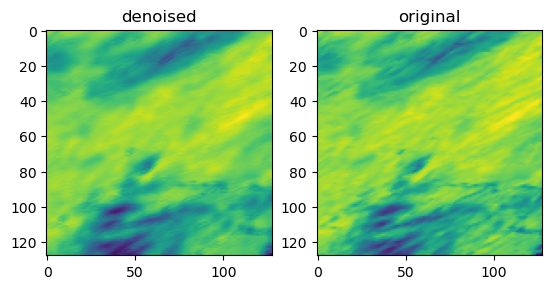

In [42]:
fig, ax = plt.subplots(1, 3)
ax[0]
ax[1].imshow(sample[1]-preds.cpu().detach().numpy().reshape(128, 128))
ax[1].set_title('denoised')
ax[2].set_title('original')
ax[2].imshow(sample[0])